In [1]:
import pandas as pd
import yfinance as yf

# Extract stock market data from Yahoo Finance and write it to a CSV file locally
def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    history = stock.history(period="max")
    history.reset_index(inplace=True)
    history = history[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    history.to_csv('stock_data.csv', index=False)

if __name__ == '__main__':
    get_stock_data('AAPL')

In [12]:
import pandas as pd
import yfinance as yf
from snowflake.connector import connect, ProgrammingError
from datetime import datetime

# Extract stock market data from Yahoo Finance
def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    history = stock.history(period="max")
    history.reset_index(inplace=True)
    history['Date'] = history['Date'].dt.strftime('%Y-%m-%d')  # Convert Date column to string format
    history = history[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    history.to_csv('stock_data.csv', index=False)
    
    # Connect to Snowflake
    conn = connect(
        user='<your_username>',
        password='<your_password>',
        account='<your_account_name>',
        warehouse='<your_warehouse_name>',
        database='<your_database_name>',
        schema='<your_schema_name>'
    )
    cursor = conn.cursor()

    # Create a table in Snowflake
    table_name = 'stock_data'
    create_table_query = f'''
    CREATE OR REPLACE TABLE {table_name} (
        Date DATE,
        Open FLOAT,
        High FLOAT,
        Low FLOAT,
        Close FLOAT,
        Volume FLOAT
    )
    '''
    cursor.execute(create_table_query)

    # Insert data into the Snowflake table
    insert_query = f'''
    INSERT INTO {table_name} (Date, Open, High, Low, Close, Volume)
    VALUES (%s, %s, %s, %s, %s, %s)
    '''
    try:
        cursor.executemany(insert_query, history.values.tolist())
        conn.commit()
    except ProgrammingError as e:
        print(f"An error occurred while inserting data: {e.msg}")

    cursor.close()
    conn.close()

if __name__ == '__main__':
    get_stock_data('AAPL')

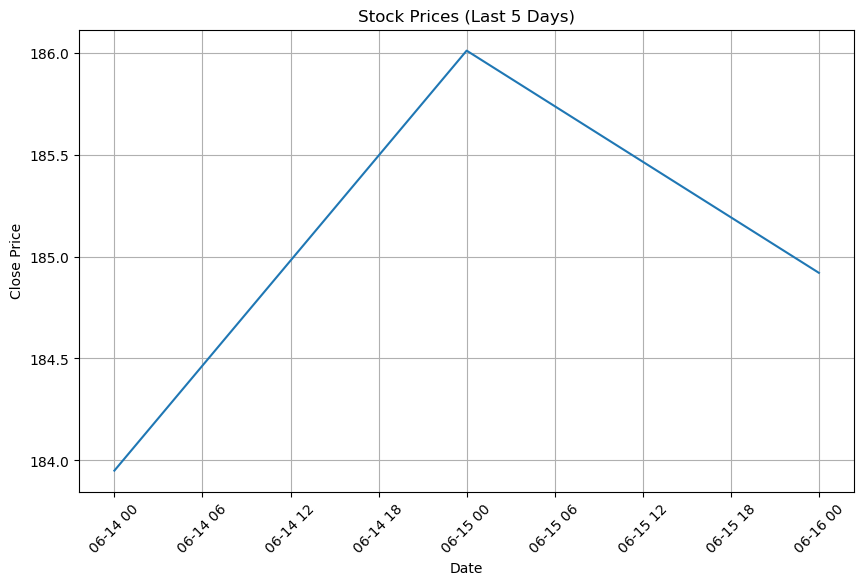

In [15]:
import pandas as pd
from snowflake.connector import connect
import matplotlib.pyplot as plt

# Retrieve stock market data from Snowflake
def get_stock_data():
    # Connect to Snowflake
    conn = connect(
        user='<your_username>',
        password='<your_password>',
        account='<your_account_name>',
        warehouse='<your_warehouse_name>',
        database='<your_database_name>',
        schema='<your_schema_name>'
    )
    cursor = conn.cursor()

    # Query Snowflake for stock data
    query = "SELECT Date, Close FROM stock_data WHERE Date >= DATEADD('DAY', -5, CURRENT_DATE())"
    cursor.execute(query)
    rows = cursor.fetchall()

    # Extract data into a Pandas DataFrame
    df = pd.DataFrame(rows, columns=['Date', 'Close'])

    # Convert Date column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])

    # Plotting the Close prices
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Close'])
    plt.title("Stock Prices (Last 5 Days)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    cursor.close()
    conn.close()

if __name__ == '__main__':
    get_stock_data()

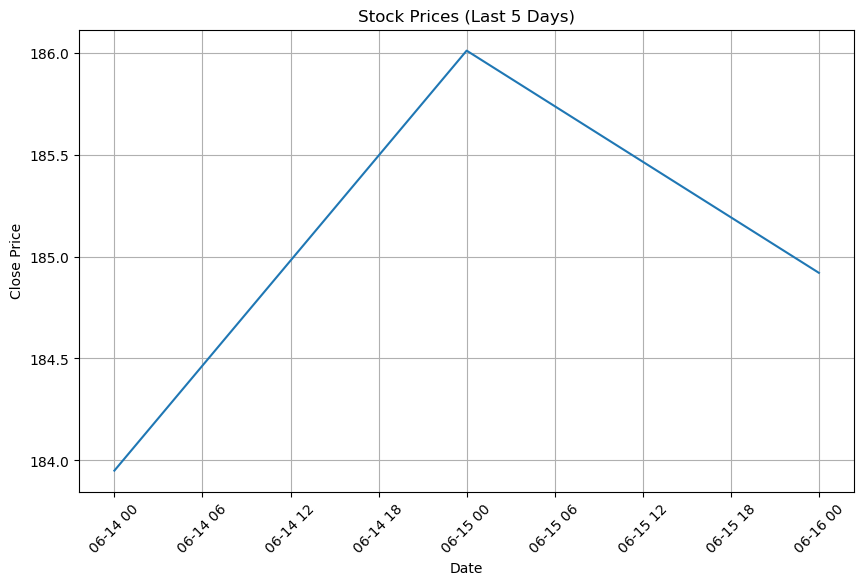

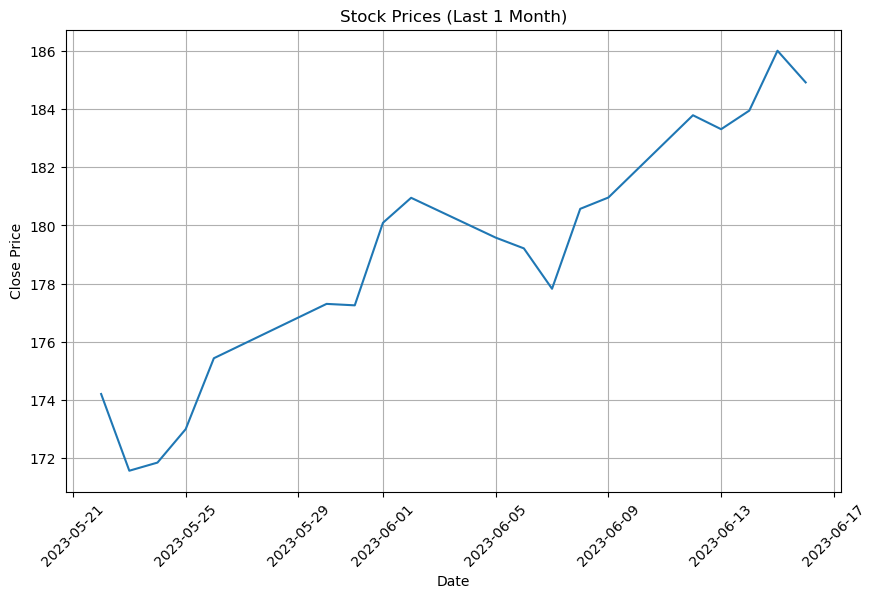

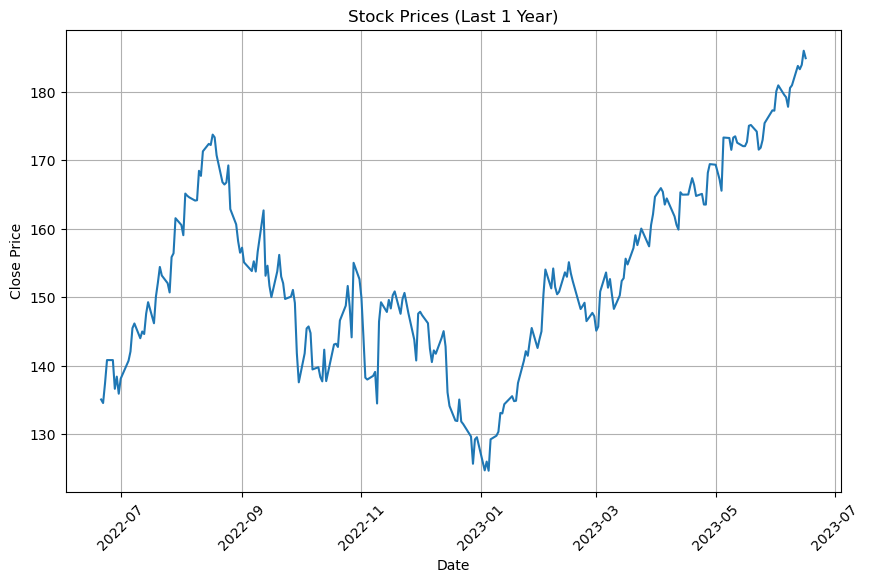

In [16]:
import pandas as pd
from snowflake.connector import connect
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Retrieve stock market data from Snowflake
def get_stock_data():
    # Connect to Snowflake
    conn = connect(
        user='<your_username>',
        password='<your_password>',
        account='<your_account_name>',
        warehouse='<your_warehouse_name>',
        database='<your_database_name>',
        schema='<your_schema_name>'
    )
    cursor = conn.cursor()

    # Define time ranges
    today = datetime.now().date()
    five_days_ago = today - timedelta(days=5)
    one_month_ago = today - timedelta(days=30)
    one_year_ago = today - timedelta(days=365)

    # Query Snowflake for stock data
    queries = [
        ("Last 5 Days", five_days_ago, today),
        ("Last 1 Month", one_month_ago, today),
        ("Last 1 Year", one_year_ago, today)
    ]

    for label, start_date, end_date in queries:
        query = f"SELECT Date, Close FROM stock_data WHERE Date BETWEEN '{start_date}' AND '{end_date}'"
        cursor.execute(query)
        rows = cursor.fetchall()

        # Extract data into a Pandas DataFrame
        df = pd.DataFrame(rows, columns=['Date', 'Close'])

        # Convert Date column to datetime type
        df['Date'] = pd.to_datetime(df['Date'])

        # Plotting the Close prices
        plt.figure(figsize=(10, 6))
        plt.plot(df['Date'], df['Close'])
        plt.title(f"Stock Prices ({label})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    cursor.close()
    conn.close()

if __name__ == '__main__':
    get_stock_data()